In [17]:

from fitparse import FitFile

from math import sqrt, pi, cos
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

from itertools import chain


#%matplotlib ipympl
R = 6371000 #earth radius [m]


In [115]:
fitfile = FitFile('fit_files/2911728087.fit')#test
#fitfile = FitFile('fit_files/2913107441.fit')#dive
fitfile = FitFile('fit_files/2913114523.fit')#swim


In [116]:
def toDegree(s): 
    s=np.array(s)
    d=s*180/2**31
    return d


def toDeltaMeter(lat_d, lng_d):
    R = 6371000 #earth radius [m]
    delta_lat_d=np.diff(lat_d)
    delta_lng_d=np.diff(lng_d)
    delta_lat_m=delta_lat_d * R * pi / 180
    delta_lng_m=delta_lng_d * R * pi / 180 * np.cos(np.array(lat_d[:-1])*pi/180)
    dist=np.sqrt(delta_lat_m**2+delta_lng_m**2)
    return(pd.DataFrame({'delta_lat': delta_lat_m,  'delta_lng': delta_lng_m, 'dist': dist}))
    
    

In [120]:
data={}
# Get all data messages that are of type record
for i, record in enumerate(fitfile.get_messages('record')):
    #print("{}___".format(i))
    # Go through all the data entries in this record
    fields=set(['position_lat_deg', 'position_long_deg', 'delta_lat','delta_long', 'delta' ])
    for record_data in record:
        # Print the records name and value (and units if it has any)
        fields.add(record_data.name)
        if i==100:
            if record_data.units:
                print (" * {}: {} {}".format(record_data.name, record_data.value, record_data.units))
            else:
                print (" * {}: {}".format(record_data.name, record_data.value))
        if record_data.name not in data:
            data[record_data.name]=[np.nan] * i
        data[record_data.name].append(record_data.value)
    for missing in set(data.keys()).difference(fields):
        data[missing].append(np.nan)
    lat_deg=data['position_lat'][-1]*180/2 ** 31
    long_deg=data['position_long'][-1]*180/2 ** 31    
    if i==0:
        data['position_lat_deg']=[lat_deg]
        data['position_long_deg']=[long_deg]
        data['delta_lat']=[0]
        data['delta_long']=[0]
        data['delta']=[0]
    else:
        data['delta_lat'].append(R * (lat_deg-data['position_lat_deg'][-1])*pi/180)
        data['delta_long'].append(R * cos(lat_deg*pi/180) * (long_deg-data['position_long_deg'][-1])*pi/180)
        data['position_lat_deg'].append(lat_deg)
        data['position_long_deg'].append(long_deg)
        data['delta'].append(sqrt(data['delta_lat'][-1]**2 + data['delta_long'][-1]**2))
        
for n in data.keys():
    if isinstance(data[n][0], tuple):
        data[n]=list(chain.from_iterable(data[n]))
    try:
        data[n]=np.array(data[n], dtype=np.float)
    except TypeError:
        print("leave "+n+ " as it is ("+ str(type(data[n][0])) +")")
    

 * accel_X: (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None) millig
 * accel_Y: (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None) millig
 * accel_Z: (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None) millig
 * altitude: 102.39999999999998 m
 * cadence: 0 rpm
 * distance: 160.3 m
 * enhanced_altitude: 102.39999999999998 m
 * enhanced_speed: 1.782 m/s
 * fractional_cadence: 0.0 rpm
 * gps_accuracy: None
 * gps_lat: None semicircles
 * gps_lng: None semicircles
 * gps_time: None
 * mag_X: (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None) mG
 * mag_Y: (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None) mG
 * mag_Z: (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None) mG
 * position_lat: 625798313 semicircles
 * position_long: 157936636 semicircles
 * pr

/pkg/python-3.6.4-2/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


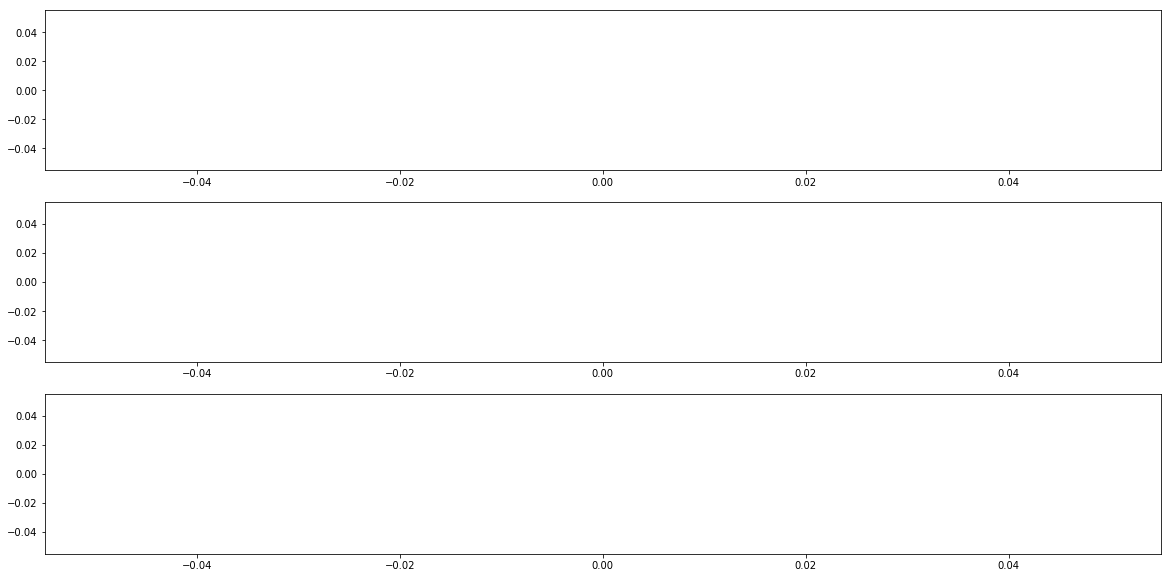

In [119]:
data['accel_X']
t = np.arange(0., i+1, 1/15)


ax = plt.subplot(3, 1, 1)

ax.plot(t, data['accel_X'], 'r--', t, data['accel_Y'], 'b--', t,data['accel_Z'], 'g--')
ax = plt.subplot(3, 1, 2)
ax.plot(t, data['mag_X'], 'r--', t, data['mag_Y'], 'b--', t,data['mag_Z'], 'g--')
ax = plt.subplot(3, 1, 3)
mWS=9807 #Pa

amb_pressure=np.median(data['pressure'][20:100])
depth=(amb_pressure-data['pressure'])/mWS*100
#ax.plot(t, (amb_pressure-data['pressure']),'--')
ax.plot(t,depth , '--' )

ax.figure.set_size_inches(20,10)

plt.show()


In [122]:

idx=np.arange(0, i+1)*15+data['gps_time']
idx[0]=0
col=np.array(["green", "red"])
cols=col[(depth[idx.astype(int)]< -.5).astype(int)]

plt.axis('equal')
plt.plot(  np.cumsum(data['delta_long']), np.cumsum(data['delta_lat']), '--')

plt.scatter(  np.cumsum(data['delta_long']), np.cumsum(data['delta_lat']), s=10,c=list(cols))
plt.show()

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 10485

In [123]:
data.keys()

dict_keys(['accel_X', 'accel_Y', 'accel_Z', 'altitude', 'cadence', 'distance', 'enhanced_altitude', 'enhanced_speed', 'fractional_cadence', 'gps_accuracy', 'gps_lat', 'gps_lng', 'gps_time', 'heart_rate', 'mag_X', 'mag_Y', 'mag_Z', 'position_lat', 'position_long', 'pressure', 'section', 'speed', 'timestamp', 'unknown_87', 'unknown_88', 'position_lat_deg', 'position_long_deg', 'delta_lat', 'delta_long', 'delta'])

In [124]:
np.arange(0, i+1)*15+data['gps_time']

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [126]:
depth[idx.astype(int)]< -1

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 10485

In [127]:
["red", "blue"][(depth[idx.astype(int)]< -1).astype(int)]

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 10485

In [128]:
(depth[idx.astype(int)]< -1).astype(int)

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 10485